__This project will analyse 2 distict datasets using unsupervised, supervised learning and graph analytics. For the first part, we wish to classify scientific papers and for the second we will classify images.__

# Initialisation

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans,MiniBatchKMeans, DBSCAN
from sklearn.metrics import calinski_harabasz_score,silhouette_score,davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,confusion_matrix,accuracy_score, classification_report
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import time
import torchvision.datasets as dsets
import torchvision.transforms
import networkx as nx
import collections
from networkx.algorithms import community
import matplotlib.colors as mcolors
from collections import OrderedDict,defaultdict
from timeit import default_timer as timer


# Preliminaries

In [0]:
features = pd.read_csv("/content/drive/My Drive/Coursework 3/feature_matrix.csv",header=None)
adjacency = pd.read_csv("/content/drive/My Drive/Coursework 3/adjacency_matrix.csv",header=None)
train=pd.read_csv("/content/drive/My Drive/Coursework 3/fashion-mnist_train.csv")
test=pd.read_csv("/content/drive/My Drive/Coursework 3/fashion-mnist_test.csv")

In [0]:
X_train=train.drop('label',axis=1)
Y_train=train['label']
X_test=test.drop('label',axis=1)
Y_test=test['label']

In [0]:

scaler=StandardScaler()

In [0]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
transformed_features=scaler.fit_transform(features)

# Task 1 

In the first part, we will analyse a series of text documents. The text in each paper has been summarized as a high dimensional vector where each coordinate of the vector shows the presence or the absence of a word. First of all, we will implement KMeans to find the optimal number of classes for the journal papers. Second of all, we will look at the graph of the citations between the papers and eventually trying to find the optimal number of communities.

## Task 1.1

We are going to start investigating the features matrix by finding an optimised clustering. For this, we are going to implement K-Means clustering algorithm. Firstly, we choose the number of clusters, k. Then, the algorithm randomly assigns the centroids to each cluster. Using the Euclidean distance, we assign the other points to the closest centroid. Then, we update the centroids by calculating the mean of the values from the cluster. The model will stop when it will converge, meaning that the centroids will stop changing. The main property that needs to be satisfied is that all points from a cluster should be similar to each other. We assess this by calculating the within sum of squared or inertia

$$ \sum_{j=1}^{k}\sum \mid\mid x_{i}-\mu_{j}\mid\mid_{2}^{2}$$

when the first sum calculates the total distance from the centroid within one cluster. Therefore, our goal is the minimise the inertia which is exactly what the k-means does through the interations. 

To be able to choose the optimal number of clusters, we will make use of the Calinski-Harabasz score 

$$ \frac{SS_{B}}{SS_{W}}\times \frac{N-k}{k-1}$$

Here, $SS_{W}$ represents the inertia and $SS_{B}$ is the overall between cluster variance which can be calculated as the total sum of squares minus $SS_{W}$. The total sum of squares is calculated as the distance between all points and the centre of the data set. 

In [0]:
#run the kmeans algorithm for values of k from 2 to 30 and calculate the CH score for each of them
k=[int(x) for x in np.linspace(2,30,29)]
values=[]
for cluster in k:
      kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
      kmeans.fit(features.values)
      labels=kmeans.labels_
      values.append(calinski_harabasz_score(features.values, labels))

Text(0, 0.5, 'CH score')

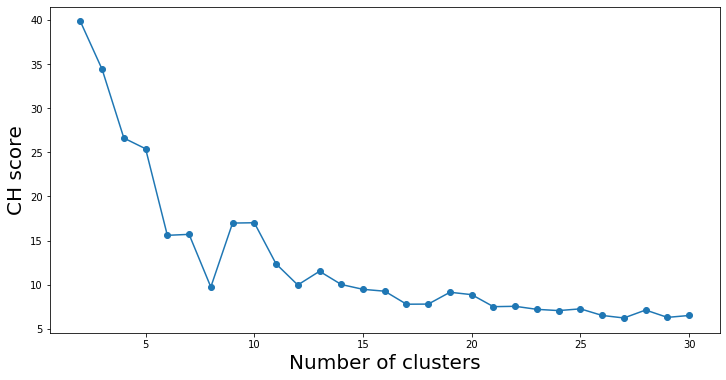

In [31]:
#plot the results from the CH score
frame = pd.DataFrame({'Cluster':range(2,31), 'metric':values})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['metric'], marker='o')
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('CH score',fontsize=20)

After running the algorithm, we are going the pick k, the first one with $\text{CH}< 7$ as our optimal clustering. 

In [32]:
frame[frame['metric']<7].iloc[[0]]

,Cluster,metric
24,26,6.514216


Therefore our optimal clustering is 26. Moving on, we will investigate the properties of our clusters.


In [34]:
#initialise the final verson of the algorithm and fit it to the data
start=timer()
optimal=frame[frame['metric']<7].iloc[[0]]
kmeans = KMeans(n_jobs = -1, n_clusters = int(optimal['Cluster']), init='k-means++')
kmeans.fit(features.values)
end=timer()
pred_kmeans=kmeans.predict(features.values)
print('Time elapsed '+ str(end-start))

Time elapsed 13.77083428700007


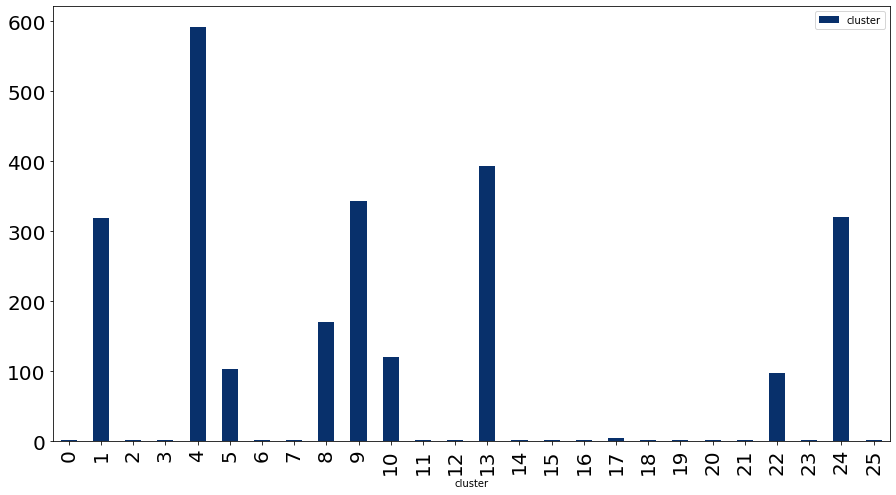

In [35]:
#plot the distribution of the cluster sizes
features['cluster']=pred_kmeans
features.groupby('cluster').agg({'cluster':'count'}).plot(kind='bar',figsize=(15,8),colormap='Blues_r',fontsize=20)

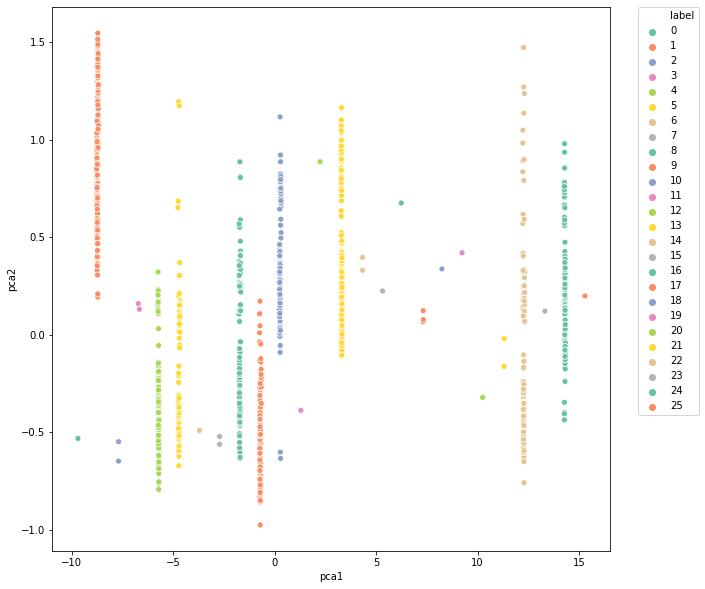

In [36]:
#visualise the clusters in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features.values)
clustering = pd.DataFrame({'pca1' : X_pca[:,0], 'pca2' : X_pca[:,1], 'label': pred_kmeans})
plt.figure(figsize=(10,10))
sns.scatterplot(x='pca1', y='pca2', hue='label', data=clustering, palette=sns.color_palette("Set2", 26), legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The __Silhouette Score__ measures how appropriate the points have been assigned to their clusters. The silhouette score for one cluster is defined as

$$\frac{b-a}{max(a,b)}$$

and the overall score is the average of all the scores. This value ranges between -1 and 1, with a values of 1 meaning well structures clusters. The parameter 'a' is defined as the mean distance between a sample and all the other points the same cluster and 'b' as the mean distance between a sample and all the other points in the next nearest cluster. Scores around 0 would indicate overlapping clusters.

The __Davies Bouldin Score__ is defined as

$$\frac{1}{k}\sum_{i=1}^{k}\max_{i\neq j}R_{ij}$$

where $R_{ij}=\frac{s_{i}+s_{j}}{d_{ij}}$ with $d_{ij}$ defined as the distance between the centroids of the clusters i and j and $s_{i}$ is the average distance between each point of the cluster i and the centroid of the cluster. 

In [15]:
#calculate silhouette score, inertia, davies bouldin and ch score
silhoutte=silhouette_score(features, pred_kmeans, metric='euclidean')
inertia=kmeans.inertia_
davies=davies_bouldin_score(features,pred_kmeans)
ch=calinski_harabasz_score(features,pred_kmeans)
evaluation_matrix=pd.DataFrame({'silhoutte score':silhoutte,'inertia':inertia,'davies bouldin score':davies,'ch score':ch},index=['optimal clustering'])
evaluation_matrix

,silhoutte score,inertia,davies bouldin score,ch score
optimal clustering,0.051587,40293.893422,2.052959,86.52192


As we can see from the distribution of cluster sizes, we currently have 7 clusters with the size at most 2. We have used the dimensionality reduction technique, PCA, mainly for visualising the clusters in 2D. K-means performs better in capturing structure of the data if clusters have a spherical shape. From our second representation, we can see that the natural shape is that of a straight line and therefore it defines the clusters as being the lines. As we can see from the silhouette score which is around 0, the classes overlap. The scientific papers share some words, but they also have a couple of different words and then,  the algorithm interprets as being from different classes. However, having a low silhouette score would mean that we might need less classes since in its calculations incorporates the distance of a point from a class to another class. 
The davies boulding score essentially evaluate the similarities between the classes. A lower value of the davies bouldin score would mean that the clusters are different, but in our case it indicates that some clusters are similar. Moreover, we should consider a lower number of clusters. 

We can clearly see the randomness of the kmeans algorithm by looking at the CH score. Initially, we would have a score of at most 7 and then it jumped to 86.52. 

## Task 1.2

In this section, we are going to investigate the properties of the citations graph and analyse how the papers are interacting with each other. For this exercise we will ignore the direction of the citations and we will assume that in paper i, the paper j is mentioned, then in paper j, paper i is mentioned as well. We will make use of the adjacency matrix to plot our graph. The term $A_{ij}$ in our adjacency matrix A is 1 if there is an edge connecting node i and node j and 0 otherwise. Our matrix is symmetric since we have an undirected graph and elements on the diagonal are zero since we do not have self edges. 

In [0]:
#get the graph from the adjacency matrix
G=nx.Graph(adjacency.values)


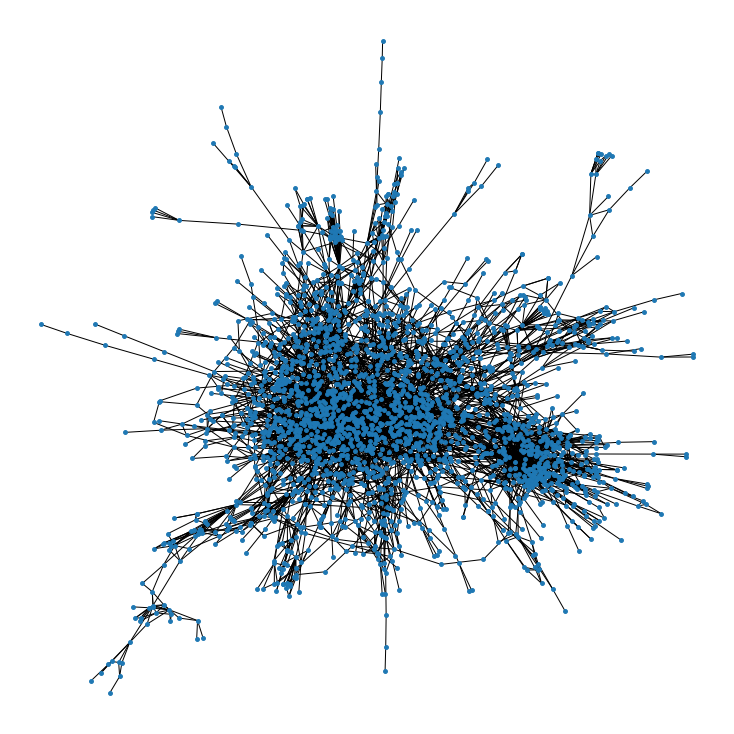

In [0]:
#display the graph
plt.figure(figsize=(10,10))
nx.draw(G,node_size=15)

The degree of a node is defined as the number of edges it has. By looking at the distributions of the degrees across the network, we can see that most of our nodes have degree values less than 25 with some outliers with values higher than 50.

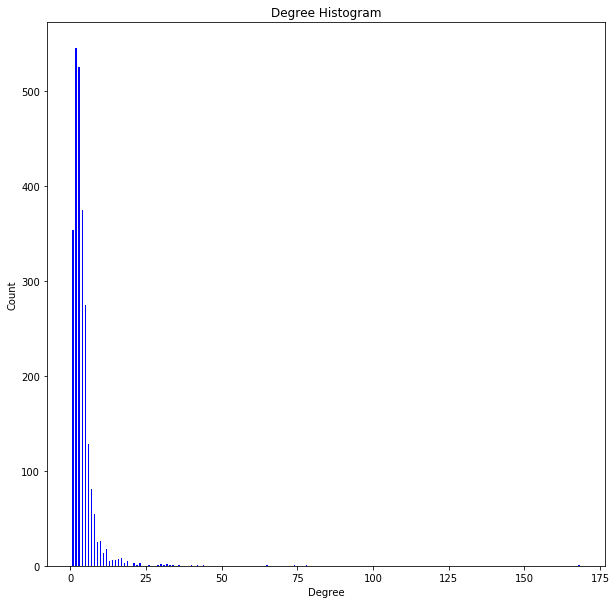

In [0]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True) #  sorted list of degrees
degreeCount = collections.Counter(degree_sequence) #count how many of each degree
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots(figsize=(10,10))
plt.bar(deg, cnt, width=0.5, color='b')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

#### i. *Degree centrality measure*



The degree centrality measure is defined in NetworkX as $\frac{degree}{n-1}$ where n is the number of nodes in the network, which in our case is 2485.

In [0]:
degree_measures=nx.degree_centrality(G)#calculate degree centraility for each node

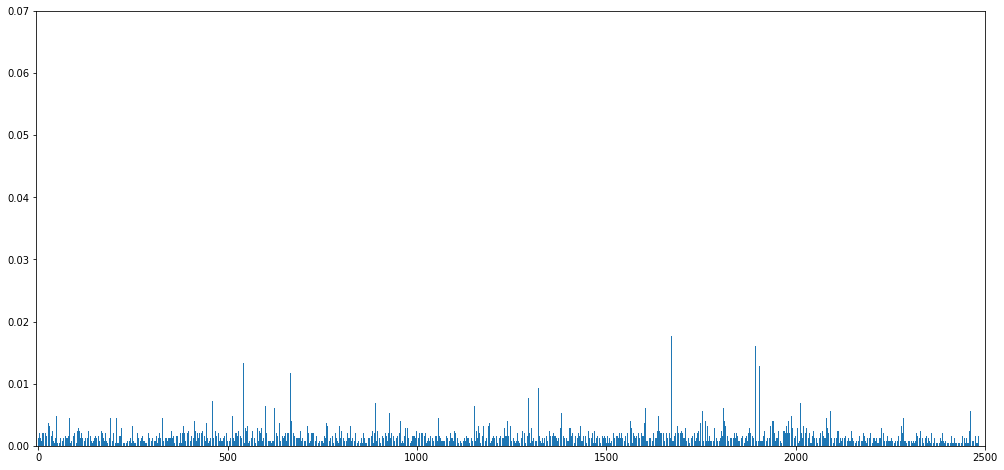

In [0]:
#plot the degree centrality measure distribution
x=[m for m in degree_measures]
y=[b for b in degree_measures.values()]
plt.figure(figsize=(17,8))
plt.bar(x,y)
plt.xlim(-5,2500)
plt.ylim(0,0.07)
plt.show()

In [0]:
#get the top 30 nodes according to this measure
top30_degree=OrderedDict(collections.Counter(degree_measures).most_common(30))
top30_degree

OrderedDict([(1245, 0.06763285024154589),
             (271, 0.03140096618357488),
             (1563, 0.029790660225442835),
             (1846, 0.02616747181964573),
             (1672, 0.017713365539452495),
             (1491, 0.016908212560386472),
             (1894, 0.01610305958132045),
             (78, 0.014492753623188406),
             (926, 0.013687600644122383),
             (542, 0.013285024154589372),
             (95, 0.01288244766505636),
             (1905, 0.01288244766505636),
             (1774, 0.01247987117552335),
             (977, 0.012077294685990338),
             (1418, 0.012077294685990338),
             (666, 0.011674718196457327),
             (1122, 0.010466988727858293),
             (951, 0.009259259259259259),
             (1071, 0.009259259259259259),
             (1321, 0.009259259259259259),
             (1362, 0.008856682769726247),
             (84, 0.008454106280193236),
             (374, 0.008454106280193236),
             (1034, 0.008454106

As we can see we have 16 nodes with number of edges greater than 25 and we can consider node 1245 a highly central one as it has 168 edges. 

#### ii. *Betweenness centrality measure*

The betweenness centrality measure is defined as $\sum_{s,t}\frac{n_{st}^{i}}{n_{st}}$ where $n^{i}_{st}$ represents the number of shortest paths (s,t) that passes through node i and $n_{st}$ is the total number of shortest paths (s,t). In the function from NetworkX, this value is normalized by $\frac{2}{(n-1)(n-2)}$ where n represents the number of nodes in the network.

In [0]:
betweenness_measure=nx.betweenness_centrality(G)#calculate the betweenness measure for each node

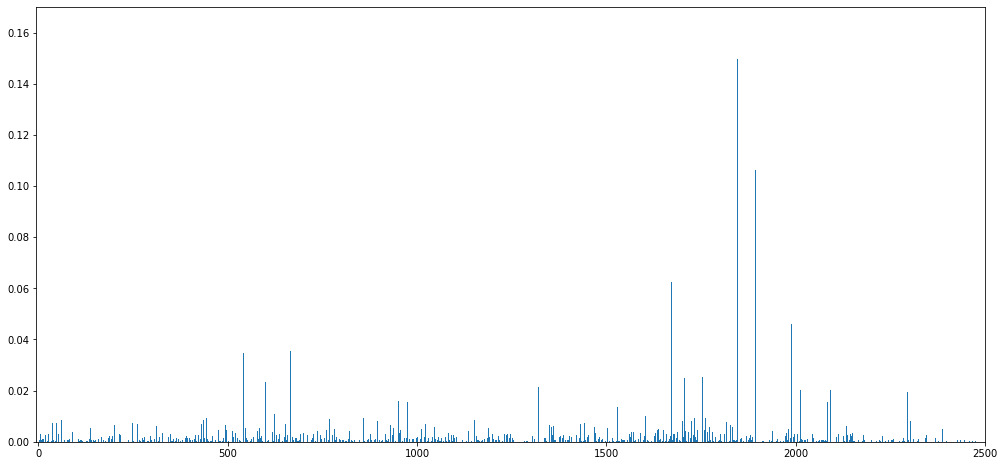

In [0]:
#plot the distribution of the betweenness measure
x=[m for m in betweenness_measure]
y=[b for b in betweenness_measure.values()]
plt.figure(figsize=(17,8))
plt.bar(x,y)
plt.xlim(-5,2500)
plt.ylim(0,0.17)
plt.show()

In [0]:
OrderedDict(collections.Counter(betweenness_measure).most_common(30))
#get the top 30 according to this measure

OrderedDict([(1245, 0.27611427872076355),
             (1846, 0.14976342886230792),
             (1894, 0.10610938587659496),
             (1563, 0.1013549617553937),
             (271, 0.09070661186764598),
             (977, 0.08066224841211615),
             (926, 0.07504358200818886),
             (1672, 0.062338184707346866),
             (78, 0.05919534503774305),
             (95, 0.048990991438395366),
             (1989, 0.04617593525696573),
             (2093, 0.041004117038147145),
             (882, 0.03867844142929861),
             (666, 0.03533415896328164),
             (542, 0.03470643045494636),
             (1905, 0.03434451271465253),
             (1122, 0.030914979621525156),
             (585, 0.030816737677138915),
             (1052, 0.02859663611453849),
             (1034, 0.028024773277948056),
             (376, 0.027005536687419292),
             (1418, 0.026220445776662677),
             (891, 0.025642353202214203),
             (472, 0.025479940607219653

Betweenness centrality plays an important role because if it were to remove a highly central node according to this measure, then the flow of information will be disrupted and it could also lead to nodes not being able to communicate with further away nodes.
Node 1245 is again the highly central according to this measure. If we are looging at the top 16, we can see that nodes 2093 and 1989 are the only ones that are not considered central if we are just taking into consideration the degree.  Node 2093 has 6 edges and node 1989 has 12 edges and they are communicating with each other. However, node 1989 is connected to node 1894 who has 40 edges and it is also considered central in terms of betweenness centrality measure. Therefore, node 1989 inherits the centrality from 1894.

#### iii. *PageRank measure*

PageRank is defined as $\alpha\sum_{j}A_{ij}\frac{x_{j}}{k_{j}^{out}} + \beta$. It then can be rewritten as $\boldsymbol{\beta}(\text{I}-\alpha AD^{-1})^{-1}\boldsymbol{1}$ where D is a diagonal matrix with $D_{ii}=\max(k_{i},1)$. Since $\beta$ is just an overall multiplier and does not play a significant role we can set it equal to 1. If we would have $\alpha\rightarrow 0$, then the score will eventually have a constant value, but if we increase $\alpha$ rapidly, the scores will diverge. The divergence will occur when $(\text{I}-\alpha AD^{-1})^{-1}$ diverges and this happens when its determinant passes through zero. Therefore, we need to set $\alpha$ less than the value of the highes eigenvalue of $AD^{-1}$ which for an undirected graph is 1. The value of $\alpha$ in our function is 0.85.

In [0]:
pagerank=nx.pagerank(G)#calcualate the pagerank measure for each node


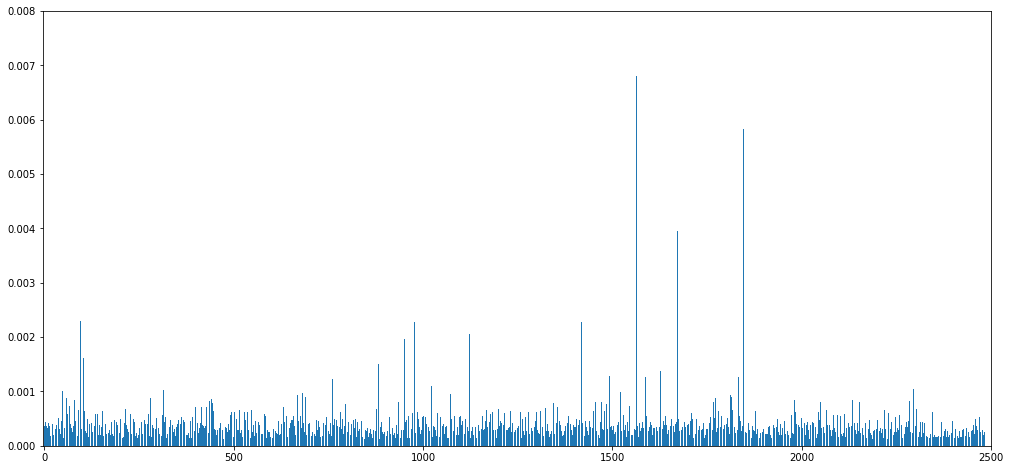

In [0]:
#plot the distribution of the pagerank measure
x=[x for x in pagerank]
y=[x for x in pagerank.values()]
plt.figure(figsize=(17,8))
plt.bar(x,y)
plt.xlim(-5,2500)
plt.ylim(0,0.008)
plt.show()

In [0]:
top30_pagerank=OrderedDict(collections.Counter(pagerank).most_common(30))#get the top 30 according to this measure
top30_pagerank


OrderedDict([(1245, 0.013301967248659882),
             (1563, 0.006811383101959031),
             (1846, 0.005832597967695927),
             (271, 0.005511379362481306),
             (1672, 0.003957178264740193),
             (1894, 0.0034709975433045164),
             (1491, 0.003042561002213162),
             (78, 0.0029167552633354694),
             (542, 0.0028745396795930777),
             (926, 0.002759376826703799),
             (1774, 0.0026334280733374977),
             (1321, 0.0026161694988695253),
             (666, 0.0025297161168855438),
             (1905, 0.0022927708192185207),
             (95, 0.0022922820337064062),
             (1418, 0.0022850282740998233),
             (977, 0.0022797831529920154),
             (1122, 0.0020603374446584617),
             (951, 0.001964996373884432),
             (1071, 0.0018248643813293611),
             (374, 0.0017189845109051062),
             (2033, 0.0016494859447609793),
             (1555, 0.0016368336302028212),
       

Node 1245 is the most central. We can see that a few of the nodes, for example 1491 and 1774, are considered central by pagerank and degree centrality measures, but they are not by betweenness centrality. PageRank is an extension of the Katz centrality which states the fact that if a node i is highly important and another node j is associated with it, then node j is considered highly imported as well. PageRank states that node j should inherit only a fraction of the centrality from node i. Therefore, you do not need to be the most influential to control the information flow of the network.

[Text(0.5, 0, 'degree centrality'),
 Text(1.5, 0, 'betweenness centrality'),
 Text(2.5, 0, 'PageRank')]

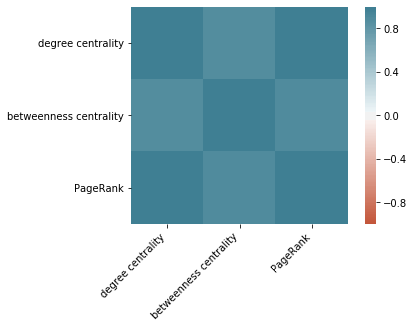

In [0]:
#plot the heatmap of the correlation between the 3 measures
quality_measure=pd.DataFrame({'degree centrality':degree_measures,'betweenness centrality':betweenness_measure,'PageRank':pagerank})
corr=quality_measure.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

From the correlation plot we can see that we have a high positive correlation between all the measures. Degree centrality is more correlated with pagerank rather than betweenness centrality which could have also been seen from the rankings as some nodes were considered central by pagerank and degree but not from betweenness. Degree captures local information, whilst betweenness centrality is calculated with respect to the whole network. PageRank has been also proved to be proportional to the degree distribution of the undirected graph. Betweenness centrality plays an import

## Task 1.3

We are going to find the optimal number of communities using the Clauset-Newman-Moore modularity maximisation algorithm. In networks, we look for the division that maximizes the modularity. Modularity is defined as 

$$\frac{1}{2m}\sum_{ij}\Big(A_{ij}-\frac{k_{i}k_{j}}{2m}\Big)\delta_{g_{i}g_{j}}$$

where $\delta$ is the Kronocker Delta function, $g_{i}$ is the class and $k_{i}$ is the degree. 

A network is assortative if a significant fraction of the edges runs between nodes of the same type. We calculate assortativity by substracting the fraction of edges we would expect to find if edges were positioned from the fractiong of edges that run between nodes of the same type. In our formula $\frac{k_{i}k_{j}}{2m}$ is the expected number of edges between nodes i and j.

In [0]:
# Creating a dictionary for the community number assocaited with each node
com=1
thisdict={}
comp=community.greedy_modularity_communities(G)
# Populating the items of the dictionary
for c in list(comp):
    list_f=sorted(c)
    for i in range(len(list_f)):
        if list_f[i] in thisdict:
            print('already found')
        else:
            thisdict.update({list_f[i]: com})
        i+=1
    com+=1

values_greedy=[thisdict.get(node) for node in G.nodes()]

We are going to represent the communities with different colours on our graph.

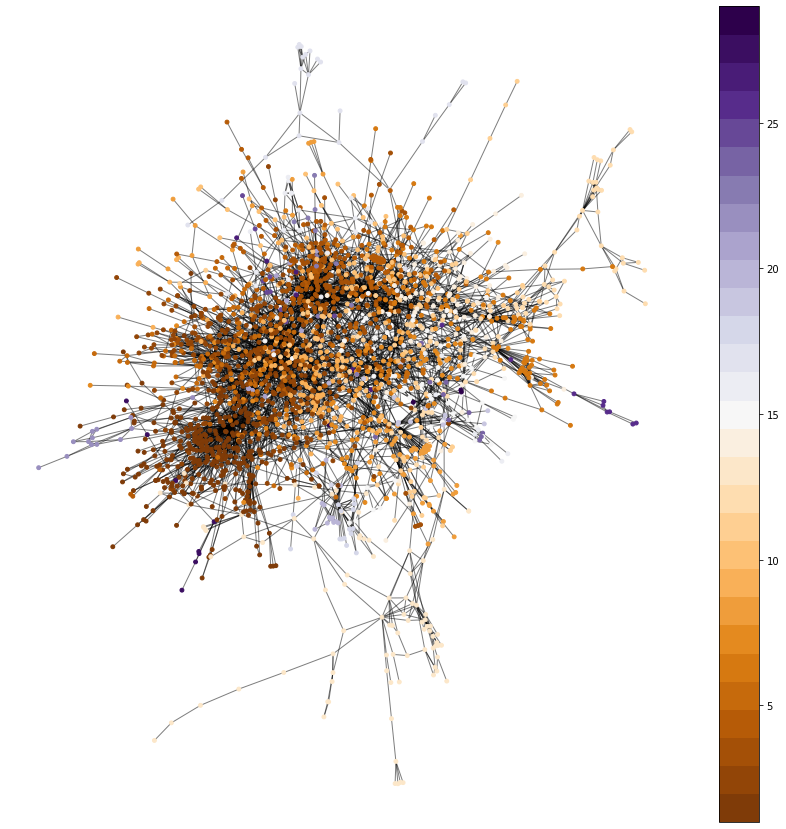

In [0]:
#display the graph according to the communities
pos=nx.spring_layout(G)
plt.figure(figsize=(15, 15))
plt.axis('off')
nodes = nx.draw_networkx_nodes(G, pos, node_size=15, cmap=plt.cm.get_cmap("PuOr", 29), node_color=values_greedy)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.colorbar(nodes)
plt.show(G)

We are going to investigate how our top 30 nodes according to degree and PageRank are distributed across the communities.

In [0]:
list_communities_degree=[]
for c in top30_degree.keys():
      list_communities_degree.append(thisdict.get(c)) #make a list of the communities that correspond to the top nodes according to degree measure

Text(0.5, 1.0, 'Distribution of top degree nodes across communities')

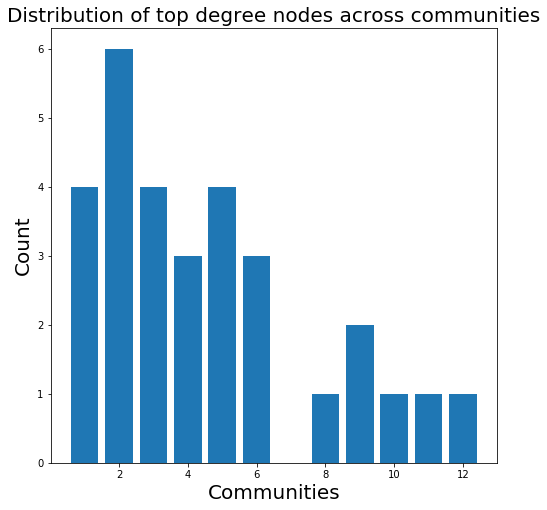

In [0]:
#plot the distribution of the top nodes across communities according to degree centrality measure
cmntCount = collections.Counter(list_communities_degree) #count how many of each degree
cmnt, cnt = zip(*cmntCount.items())
plt.figure(figsize=(8,8))
plt.bar(cmnt,cnt)
plt.xlabel('Communities',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.title('Distribution of top degree nodes across communities',fontsize=20)

In [0]:
list_communities_page=[]
for c in top30_pagerank.keys():
    list_communities_page.append(thisdict.get(c))#make a list of the communities that correspond to the top nodes according to pagerank measure

Text(0.5, 1.0, 'Distribution of top PageRank nodes across communities')

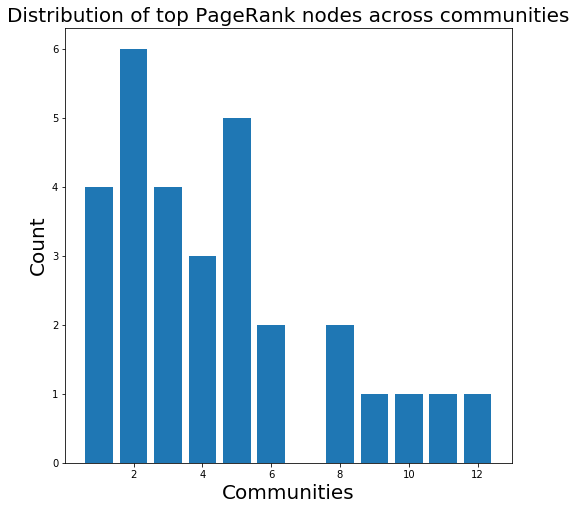

In [0]:
#plot the distribution of the top nodes across communities according to pagerank centrality measure
cmntCount = collections.Counter(list_communities_page) #count how many of each degree
cmnt, cnt = zip(*cmntCount.items())
plt.figure(figsize=(8,8))
plt.bar(cmnt,cnt)
plt.xlabel('Communities',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.title('Distribution of top PageRank nodes across communities',fontsize=20)

Text(0.5, 1.0, 'Distribution of the sizes of the communities')

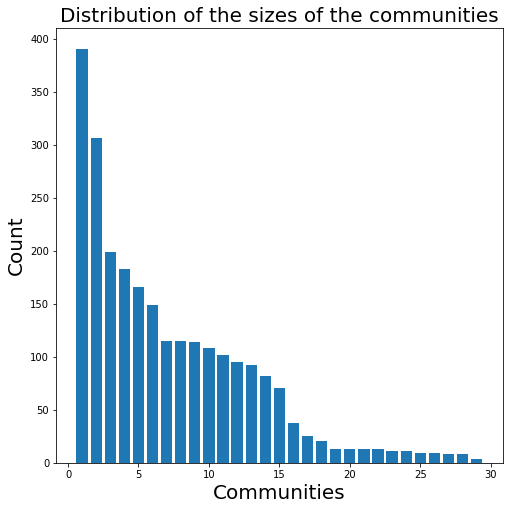

In [0]:
#plot the distribution of the sizes of the communities
cmntCount = collections.Counter(thisdict.values()) #count how many of each degree
cmnt, cnt = zip(*cmntCount.items())
plt.figure(figsize=(8,8))
plt.bar(cmnt,cnt)
plt.xlabel('Communities',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.title('Distribution of the sizes of the communities',fontsize=20)

First of all, we can see that the nodes are distributed amongst the most populated communities and we can assume that those communities are influential. Second of all, even if we have nodes that do not appear in both rankings, we can still find them across the same communities as the others. As we know, PageRank makes use of the degree in its formula and it is also proportional to the degree distribution, therefore we would expect similar communities for the nodes.

## Task 1.4

In this part, we are going to compare the clusterings that have resulted from kmeans and communities algorithm. We are going to use Adjusted Mutual Information Score and Adjusted Rand Index. 

Adjusted Mutual Information is defined as

$$AMI(U,V)=\frac{MI(U,V)-E\{MI(U,V)\}}{\max\{H(U),H(V)\}-E\{MI(U,V)\}}
$$

where $MI(U,V)$ is the Mutual Information Score and H(U) is the entropy of clustering U. The Mutual Information Score is defined as $\sum_{i}\sum_{j}P(i,j)log\frac{P(i,j)}{P(i)P'(j)}$ where $P(i,j)=\frac{\mid U_{i}\cap V_{j}\mid}{N}$ represents the probability that a point belongs to both $U_{i}$ and $V_{j}$, P(i) is the probability that a point falls into cluster $U_{i}$.

Adjusted Rand Index is defined as

$$\frac{RI-E\{RI\}}{\max(RI)-E\{RI\}}$$

where RI is the Rand Index and it is defined as $\frac{a+b}{n \choose 2}$ where a is number of pairs of elements that are in the same subset in U as in V and b is the number of pairs that are in different subsets in U and V.

Given that we are not aware of the real ground truth of the labels and the fact that the scores are symmetric, we can test if the clusterings agree with each other by switching labels_true and labels_pred in our formula. We should get similar values of they agree with each other. 

In [0]:
adjusted_mutual_info_score(pred_kmeans,np.array(values_greedy,dtype=np.int32))

0.1735034187957745

In [0]:
adjusted_mutual_info_score(np.array(values_greedy,dtype=np.int32),pred_kmeans)

0.1735034187957712

In [0]:
adjusted_rand_score(pred_kmeans,np.array(values_greedy,dtype=np.int32))

0.08323901096826725

In [0]:
adjusted_rand_score(np.array(values_greedy,dtype=np.int32),pred_kmeans)

0.08323901096826725

Looking at the values, we can conclude that the clusterings follow the same structure.

We will plot the clusters we obtained from the KMeans algorithm onto our graph so that we can inspect the differences.

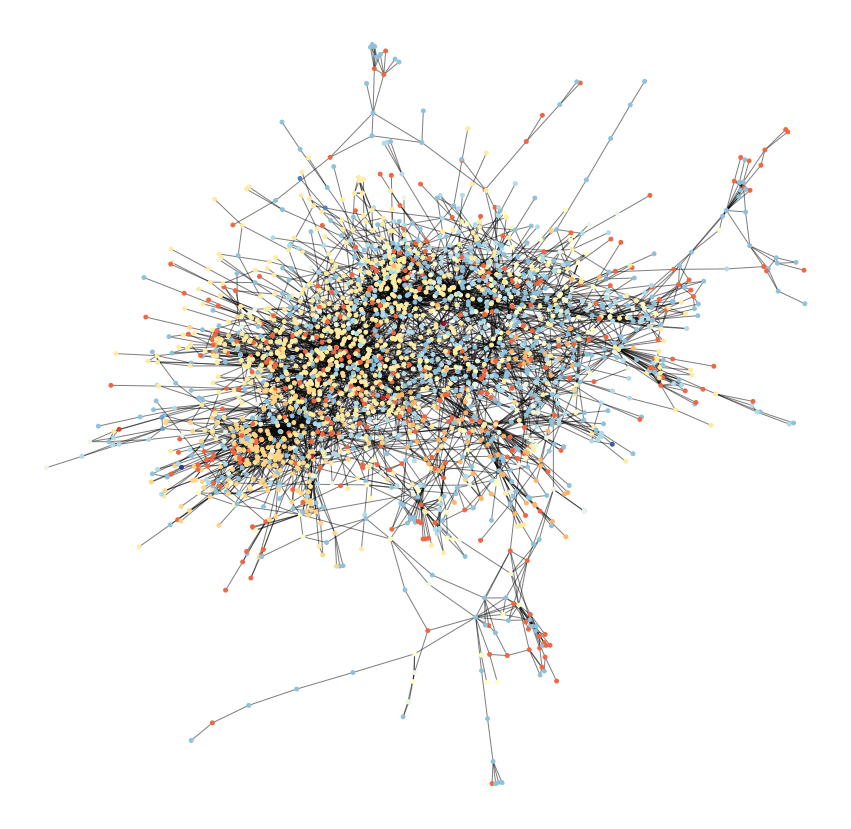

In [0]:
plt.figure(figsize=(15, 15))
plt.axis('off')
nodes = nx.draw_networkx_nodes(G, pos, node_size=15, cmap=plt.cm.RdYlBu, node_color=pred_kmeans)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show(G)

First of all, the community algorithm considered points that are linked together and closer to be from the same class whereas KMeans did not. In the feature dataset, each paper was characterised by the words that were used in the paper and intuitively the KMeans algorithm considered papers that were using similar words from the same class. Looking at the community algorithm, we clustered the papers by the interaction that they had. If they were quoting each other more, the algorithm assumed that they are from the same class. There are flaws with both algorithms as not all the time we quote papers from the same class and two different mathematics authors may use different words.

# Task 2

In the second part, we are going to work with the Fashion Mnist dataset which contains images of clothes that correspond to 10 classes. We will attempt to build a model that will classify these images. We will look at both supervised and unsupervised learning.

### Task 2.1

For this dataset we are aware of the ground truth and we know that there are 10 classes. We will use MiniBatchKMeans to investigate the existence of these classes. We will run MiniBatchKMeans for values of k from 2 to 30. We will calculate inertia and CH score for each of these k.

In [0]:
k=[int(x) for x in np.linspace(2,30,29)]
values=[]
inertia=[]
for cluster in k:
      kmeans = MiniBatchKMeans(batch_size=2000, n_clusters = cluster, init='k-means++')
      kmeans.fit(X_train)
      labels=kmeans.labels_
      values.append(calinski_harabasz_score(X_train, labels))
      inertia.append(kmeans.inertia_)

Text(0, 0.5, 'CH score')

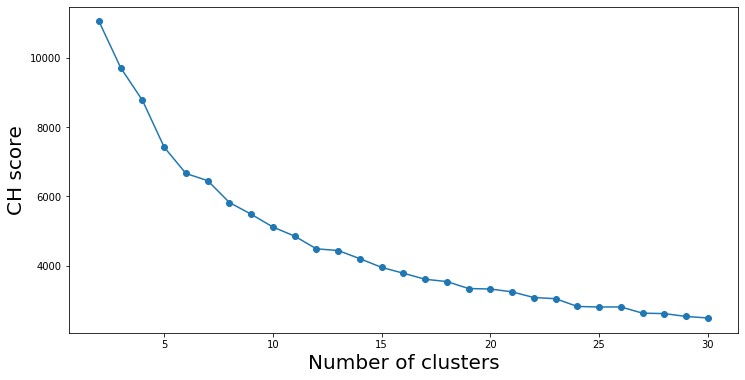

In [0]:
fashion_frame = pd.DataFrame({'Cluster':range(2,31), 'metric':values,'inertia':inertia})
plt.figure(figsize=(12,6))
plt.plot(fashion_frame['Cluster'], fashion_frame['metric'], marker='o')
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('CH score',fontsize=20)

Text(0, 0.5, 'Inertia score')

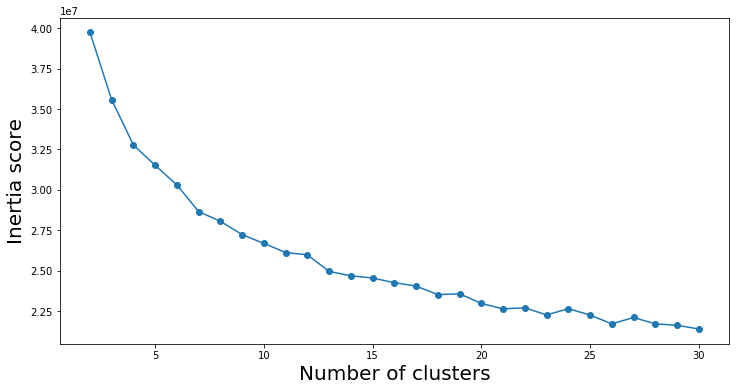

In [0]:
plt.figure(figsize=(12,6))
plt.plot(fashion_frame['Cluster'], fashion_frame['inertia'], marker='o')
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Inertia score',fontsize=20)

One method of finding the optimal number of clusters is to look at the distribution of the Inertia Score and choose the value of k where the score is starting to converge. 

In [29]:
#fit a KMeans with k=10 to our data
start=timer()
kmeans = KMeans(n_jobs = -1, n_clusters = 10, init='k-means++', random_state=42)
clusters=kmeans.fit_predict(X_train)
end=timer()
print('Time elapsed ' + str(end-start))

Time elapsed 109.98370593900017


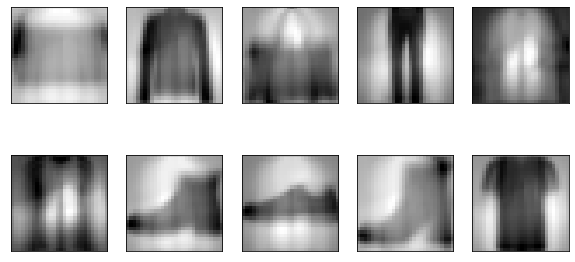

In [0]:
#visualise the centroids 
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
centers = kmeans.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

As we can see, each class corresponds to one of the fashion items. We can see that the T-Shirt, sneaker, boot, trousers and bag are clear images. Having the centroids as clear images and distinguishable affects the accuracy of each class which can be seen form the confusion matrix. Out of 1000 just 358 were misclassified as being from a different class for T-shirt. The same can be applied to trousers which from 1000 we misclassified just 95. The same reasoning can be applied to ankle boots, sneaker and bag. The pullovers were either misclassified as being a coat or a shirt and from the centroids we can see that we are not able to see which one is a coat or a shirt. 

In [0]:
from scipy.stats import mode
clusters_test=kmeans.predict(X_test)
labels = np.zeros_like(clusters_test)
for i in range(10):
    mask = (clusters_test == i)
    labels[mask] = mode(Y_test[mask])[0]

In [0]:
accuracy_score(Y_test,labels)

0.551

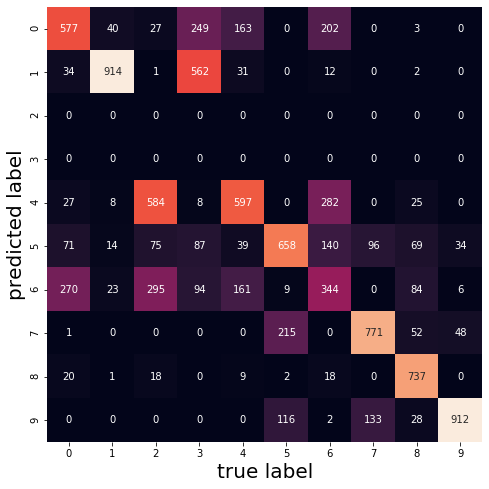

In [0]:
mat = confusion_matrix(Y_test, labels)
plt.figure(figsize=(8,8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=range(0,10),
            yticklabels=range(0,10))
plt.xlabel('true label',fontsize=20)
plt.ylabel('predicted label',fontsize=20);

#### Task 2.2.1

We will implement a feed-forward neural network with 3 hidden layers, each having 100 neurons. We are using the Relu activation function, the optimisation method is Stochastic Gradient Descend and the loss function is cross-entropy. We will train on batches of 128 data points with learning rate of 0.005 for 30 epochs. 

The power of neural networks comes from their ability to learn a mapping. Each neuron will have weights assigned to their inputs plus the bias. Starting with the input layer, we calcualte the wighted sum and then we feed into the activation function, which in our case is Relu. We take the output and then feed it into the next layer and then we continue till we reach the end. At the end we compute the errors between the desired output and the predicted out. We compute how much each of the neurons from the previous layer contributed to the errors and we keep going till we reach the beginning. This is called backpropagation algorithm. Finally, we change the weights to reduce the erros - Gradient Descent. We use the learning rate, to decide how much we are going to update the weights. This means that a learning rate of 0.005 would mean that weights in the network are updated 0.005 * (estimated weight error).
$$w_{j+1}=w_{j}+\eta\nabla \text{E}_{n}(w_{j})$$
where $\eta$ is the learning rate and $\text{E}_{n}(w_{j})$ is the derivative of the error with respect to the weight.

In [0]:
#set up the parameters
input_size = 28*28
hidden_size = 100
num_classes = 10
num_epochs = 30
batch_size = 128
learning_rate = 0.005


In [0]:
#set up the torch tensor that is going to be added into the tensordataset
X_train_2 = torch.from_numpy(X_train).float()
y_train_2 = torch.from_numpy(Y_train.values)
X_test_2 = torch.from_numpy(X_test).float()
y_test_2 = torch.from_numpy(Y_test.values)

In [0]:
#transform into a TensorDataset so we can feed it into the neural network
train = torch.utils.data.TensorDataset(X_train_2, y_train_2)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,shuffle=True)
test = torch.utils.data.TensorDataset(X_test_2, y_test_2)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,shuffle=True)

In [0]:
#initialise the neural network with 3 hidden layers and relu activation function
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))#relu activation function 
        out = F.relu(self.fc2(out))#relu activation function
        out = F.relu(self.fc3(out))#relu activation function
        out = self.fc4(out)
        return out

In [0]:
net = NeuralNet(input_size, hidden_size, num_classes)
#cross-entropy as loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent as optimiser
optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate) 

In [21]:
start=timer()
loss_values=[]#list of training loss values
for epoch in range(num_epochs):
      train_loss = 0.0
      net.train()
    ###################
    # train the model #
    ###################
      for data, target in train_loader:
          data = data.reshape(-1, 28*28)
       
        # clear the gradients of all optimized variables
          optimiser.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
          output = net(data)
        # calculate the loss
          loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
        # perform a single optimization step (parameter update)
          optimiser.step()
        # update running training loss
          train_loss += loss.item()*data.size(0) #data.size(0) is 64
        
    
    # calculate average loss over an epoch
      train_loss = train_loss/len(train_loader.dataset)
      loss_values.append(train_loss)
      
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
end=timer()

Epoch: 1 	Training Loss: 2.146577
Epoch: 2 	Training Loss: 1.297843
Epoch: 3 	Training Loss: 0.792745
Epoch: 4 	Training Loss: 0.649543
Epoch: 5 	Training Loss: 0.583299
Epoch: 6 	Training Loss: 0.540784
Epoch: 7 	Training Loss: 0.509404
Epoch: 8 	Training Loss: 0.485188
Epoch: 9 	Training Loss: 0.465330
Epoch: 10 	Training Loss: 0.448522
Epoch: 11 	Training Loss: 0.434279
Epoch: 12 	Training Loss: 0.421880
Epoch: 13 	Training Loss: 0.411343
Epoch: 14 	Training Loss: 0.401733
Epoch: 15 	Training Loss: 0.393094
Epoch: 16 	Training Loss: 0.385287
Epoch: 17 	Training Loss: 0.378605
Epoch: 18 	Training Loss: 0.372225
Epoch: 19 	Training Loss: 0.366126
Epoch: 20 	Training Loss: 0.360672
Epoch: 21 	Training Loss: 0.355405
Epoch: 22 	Training Loss: 0.350557
Epoch: 23 	Training Loss: 0.346167
Epoch: 24 	Training Loss: 0.341548
Epoch: 25 	Training Loss: 0.337573
Epoch: 26 	Training Loss: 0.333764
Epoch: 27 	Training Loss: 0.329865
Epoch: 28 	Training Loss: 0.326062
Epoch: 29 	Training Loss: 0.3

In [22]:
print('Time elapsed ' + str(end-start))

Time elapsed 33.20735767000019


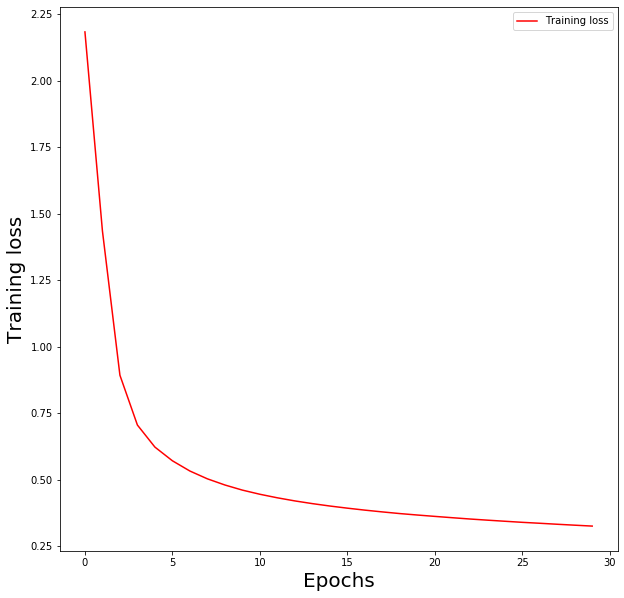

In [24]:
plt.figure(figsize=(10,10))
plt.plot(loss_values,label='Training loss',color='r')
plt.ylabel('Training loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.legend()

In [25]:
#evaluate the MLP
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correct = 0
total = 0
net.eval()
for images, labels in test_loader:
    images = images.reshape(-1, 28*28)
    labels = labels
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.data).squeeze()
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    for i in range(10):
        label = labels.data[i]
        class_correct[label] += c[i]
        class_total[label] += 1
for i in range(10):
        print('Accuracy of {} : {} / {} = {:.4f} %'.format(i, 
class_correct[i], class_total[i], 100 * class_correct[i].item() / 
class_total[i]))           
print('Accuracy of the network: {} %'.format(100 * correct / total))

Accuracy of 0 : 78.0 / 88.0 = 88.6364 %
Accuracy of 1 : 72.0 / 76.0 = 94.7368 %
Accuracy of 2 : 68.0 / 83.0 = 81.9277 %
Accuracy of 3 : 69.0 / 82.0 = 84.1463 %
Accuracy of 4 : 57.0 / 71.0 = 80.2817 %
Accuracy of 5 : 75.0 / 81.0 = 92.5926 %
Accuracy of 6 : 48.0 / 73.0 = 65.7534 %
Accuracy of 7 : 68.0 / 83.0 = 81.9277 %
Accuracy of 8 : 65.0 / 67.0 = 97.0149 %
Accuracy of 9 : 79.0 / 86.0 = 91.8605 %
Accuracy of the network: 87.37 %


The accuracy is above 70% for all the classes except for class 5 which are sandal. Considering all the images, the sandal would have the least white lines as it is the smalled fashion item so the model have not captured all the details. We have accuracy above 90% for trousers, sneaker, bag and ankle boots. 



## Task 2.2.2

We will implement a convulational neural network which will have 2 convulations layers and 3 fully connected layers. Our input is 28x28x1 which stands for height, width, depth. Our depth is 1 as we have a grey picture and we would have 3 for a RGB picture. 

The main block in our model is the convulational layer. It applies a kernel to the input data to produce a feature map. We start with one image as a 28x28 matrix and we perform the convulation operation by sliding over the image a 5x5 kernel to produce a feature map. As the filter is convolving over the image it performs element wise multiplications which are summed up to produce a single number. In our example, we are going to use 6 distinct kernels that will each capture different features of the image. The resulting feature map will have size 6x24x24. We then apply a Relu activation function to ensure that all values are positive.

With the next layer, to reduce dimensionality, we will implement maxpooling layer with a stride of 2 and kernel size of 2. This will return the maximum value from the sample covered by the kernel. 

Moreover, we apply another convulational layer and a maxpooling which leads to a size of 4x4x16. This is flatten into a vector and fed into a feedforward neural network which was explained in the previous section. 

Backpropagation follows the same structure as in multilayer perceptron and we will keep the same number of epochs, learning rate and batch size.

In [0]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

    self.fc1 = nn.Linear(in_features=16*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.out = nn.Linear(in_features=84, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1,16*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)

    return t

In [24]:
start=timer()
loss_values=[]#list of training loss values
network=Network()
#stochastic gradient descent as optimiser
optimiser_cnn = torch.optim.SGD(network.parameters(), lr=learning_rate)
#set up the torch tensor that is going to be added into the tensordataset
X_train_2 = torch.from_numpy(X_train).float()
y_train_2 = torch.from_numpy(Y_train.values) 
#transform into a TensorDataset so we can feed it into the neural network
train = torch.utils.data.TensorDataset(X_train_2, y_train_2)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,shuffle=True)
network.train()
for epoch in range(num_epochs):
      train_loss = 0.0
    ###################
    # train the model #
    ###################
      for data, target in train_loader:
          data=data.reshape(-1,1,28,28)       
        # clear the gradients of all optimized variables
          optimiser_cnn.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
          output = network(data)
        # calculate the loss
          loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
        # perform a single optimization step (parameter update)
          optimiser_cnn.step()
        # update running training loss
          train_loss += loss.item()*data.size(0) 
        
    
    # calculate average loss over an epoch
      train_loss = train_loss/len(train_loader.dataset)
      loss_values.append(train_loss)
      
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
end=timer()

Epoch: 1 	Training Loss: 2.201692
Epoch: 2 	Training Loss: 1.219051
Epoch: 3 	Training Loss: 0.915057
Epoch: 4 	Training Loss: 0.839752
Epoch: 5 	Training Loss: 0.782084
Epoch: 6 	Training Loss: 0.738336
Epoch: 7 	Training Loss: 0.699796
Epoch: 8 	Training Loss: 0.670127
Epoch: 9 	Training Loss: 0.643584
Epoch: 10 	Training Loss: 0.616858
Epoch: 11 	Training Loss: 0.595753
Epoch: 12 	Training Loss: 0.576163
Epoch: 13 	Training Loss: 0.557944
Epoch: 14 	Training Loss: 0.541786
Epoch: 15 	Training Loss: 0.525444
Epoch: 16 	Training Loss: 0.513533
Epoch: 17 	Training Loss: 0.500184
Epoch: 18 	Training Loss: 0.488575
Epoch: 19 	Training Loss: 0.477484
Epoch: 20 	Training Loss: 0.467637
Epoch: 21 	Training Loss: 0.456891
Epoch: 22 	Training Loss: 0.447309
Epoch: 23 	Training Loss: 0.438309
Epoch: 24 	Training Loss: 0.428697
Epoch: 25 	Training Loss: 0.421268
Epoch: 26 	Training Loss: 0.413879
Epoch: 27 	Training Loss: 0.406182
Epoch: 28 	Training Loss: 0.400462
Epoch: 29 	Training Loss: 0.3

In [25]:
print('Time elapsed ' + str(end-start))

Time elapsed 229.43714074800005


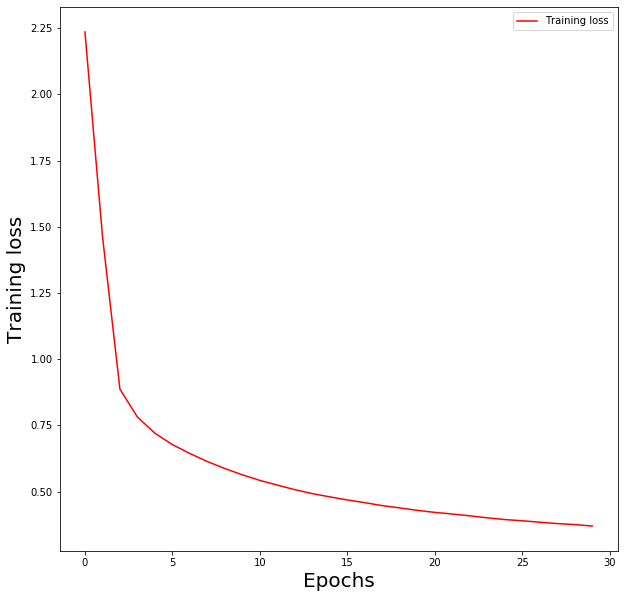

In [29]:
plt.figure(figsize=(10,10))
plt.plot(loss_values,label='Training loss',color='r')
plt.ylabel('Training loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.legend()

In [32]:
#evaluate the CNN
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correct = 0
total = 0
network.eval()
for images, labels in test_loader:
    images = images.reshape(-1, 1,28,28)
    labels = labels
    outputs = network(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.data).squeeze()
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    for i in range(10):
        label = labels.data[i]
        class_correct[label] += c[i]
        class_total[label] += 1
for i in range(10):
        print('Accuracy of {} : {} / {} = {:.4f} %'.format(i, 
class_correct[i], class_total[i], 100 * class_correct[i].item() / 
class_total[i]))           
print('Accuracy of the network: {} %'.format(100 * correct / total))

Accuracy of 0 : 63.0 / 80.0 = 78.7500 %
Accuracy of 1 : 87.0 / 89.0 = 97.7528 %
Accuracy of 2 : 66.0 / 81.0 = 81.4815 %
Accuracy of 3 : 64.0 / 75.0 = 85.3333 %
Accuracy of 4 : 70.0 / 82.0 = 85.3659 %
Accuracy of 5 : 64.0 / 70.0 = 91.4286 %
Accuracy of 6 : 60.0 / 87.0 = 68.9655 %
Accuracy of 7 : 78.0 / 82.0 = 95.1220 %
Accuracy of 8 : 66.0 / 67.0 = 98.5075 %
Accuracy of 9 : 71.0 / 77.0 = 92.2078 %
Accuracy of the network: 86.69 %


### Task 2.2.3

The accuracy of the MLP is higher than the one from CNN. The accuracy for the class 6 increased with CNN, but the one from 0 dropped significantly. MLP manages to captures combinations of the features that are given by the pixels and CNN is an extension of it and itself it incorporates the architecture of MLP. Because of the feature map and the kernel, CNN can isolate different characteristics of an image. The number of parameters is substantially higher in CNN than in MLP which can be seen from the first dense layer in CNN. CNN has a more complex architecture with more complicated layers than MLP. In our example they have used the same activation function. In terms of training time, CNN requires more time than MLP and that leads also to fewer epochs. 

The accuracy of the CNN and the MLP is much higher than the one of the kNN classifier. However, the methods that these models are very different. KMeans mainly relies on the Eucledian distance and the CNN or MLP follows a much more complex algorithm. The first thing that we can conclude is that for image recognition a more complex method is required. As well, the neural networks perform dimensionality reduction in their algorithms which helped as well increase the accuracy compared to the kNN classifier. One of most important difference between the neural networks and kNN which sets them apart is the ability to improve the Cross-Entropy loss during training. Because the ground truth is available to the neural network, the model is able to make adjustments and increase the accuracy while it is training. This is something that it is not possible for kNN. 

To be able to increase the accuracy of the CNN above 90%, the first thing that I have changed is the number of channels in our Convulational Layers. I believe that having more kernels helped finding more characteristics in each image which can be seen from the fact that the accuracy of the class 6 increased significantly. Second of all, I have added a padding of 1 to each layer and the reason I did that is that because we were using a kernel of 5, we were not able to capture the last part of the image as many times as the first one. We were making the output size of the image much closer to the input after convulating the kernel. Moreover, I have addded a Batch Normalisation layer after the convulation layers. Batch Normalisation deals with the internal covariance shift resulting from the change in the distribution of the inputs. This layer will normalise the inputs and it will accelerate the training. This has also allowed for the learning rate to increase. The higher order interactions between variables affect the loss function. For example, when we are trying to optimise a function f(w) and we consider what happens when we take a step in the direction of the gradient with size $\eta$, the loss function becomes $f(w_{O}-\eta\nabla)=f(w_{0})+(w-w_{0})^{T}\nabla+\frac{1}{2}(w-w_{0})^{T}H(w-w_{0})$. Looking at the last term, if it would be 0 then the loss would strictly decrease, but this happes only in strictly linear models. This term represents the effect of the curvature of the loss function and if the curvature is small the gradient is mostly constant and we can take large learning rate. Therefore, Batch Normalisation ensures the the higher order interactions are surpressed. The only drawback is that the training time increased.


In [0]:
learning_rate_cnn=0.01
# Build the neural network, expand on top of nn.Module
class Network2(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding = 1)
    self.bn1   = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding = 1 )
    self.bn2   = nn.BatchNorm2d(64)
    self.fc1 = nn.Linear(in_features=64*11*11, out_features=700)
    self.fc2 = nn.Linear(in_features=700, out_features=100)
    self.out = nn.Linear(in_features=100, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = self.bn1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t=  self.bn2(t)
    t = F.relu(t)
  
    # fc1
    t = t.reshape(-1,64*11*11)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)

    return t

In [27]:
start=timer()
loss_values=[]#list of training loss values
network2=Network2()
#set up the torch tensor that is going to be added into the tensordataset
X_train_2 = torch.from_numpy(X_train).float()
y_train_2 = torch.from_numpy(Y_train.values) 
#transform into a TensorDataset so we can feed it into the neural network
train = torch.utils.data.TensorDataset(X_train_2, y_train_2)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,shuffle=True)
#stochastic gradient descent as optimiser
optimiser_cnn = torch.optim.SGD(network2.parameters(), lr=learning_rate_cnn) 
for epoch in range(10):
      network2.train()
      train_loss = 0.0
    ###################
    # train the model #
    ###################
      for data, target in train_loader:
          data=data.reshape(-1,1,28,28)       
        # clear the gradients of all optimized variables
          optimiser_cnn.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
          output = network2(data)
        # calculate the loss
          loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
        # perform a single optimization step (parameter update)
          optimiser_cnn.step()
        # update running training loss
          train_loss += loss.item()*data.size(0) 
        
    
    # calculate average loss over an epoch
      train_loss = train_loss/len(train_loader.dataset)
      loss_values.append(train_loss)
      
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
end=timer()

Epoch: 1 	Training Loss: 0.756633
Epoch: 2 	Training Loss: 0.402312
Epoch: 3 	Training Loss: 0.334615
Epoch: 4 	Training Loss: 0.296656
Epoch: 5 	Training Loss: 0.270795
Epoch: 6 	Training Loss: 0.250825
Epoch: 7 	Training Loss: 0.232340
Epoch: 8 	Training Loss: 0.218123
Epoch: 9 	Training Loss: 0.202961
Epoch: 10 	Training Loss: 0.192336


In [28]:
print('Time elapsed ' + str(end-start))

Time elapsed 904.1512488820001


In [0]:
#evaluate the CNN
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correct = 0
total = 0
network2.eval()
for images, labels in test_loader:
    images = images.reshape(-1, 1,28,28)
    labels = labels
    outputs = network2(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.data).squeeze()
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    for i in range(10):
        label = labels.data[i]
        class_correct[label] += c[i]
        class_total[label] += 1
for i in range(10):
        print('Accuracy of {} : {} / {} = {:.4f} %'.format(i, 
class_correct[i], class_total[i], 100 * class_correct[i].item() / 
class_total[i]))           
print('Accuracy of the network: {} %'.format(100 * correct / total))

Accuracy of 0 : 46.0 / 58.0 = 79.3103 %
Accuracy of 1 : 88.0 / 90.0 = 97.7778 %
Accuracy of 2 : 73.0 / 87.0 = 83.9080 %
Accuracy of 3 : 73.0 / 79.0 = 92.4051 %
Accuracy of 4 : 69.0 / 76.0 = 90.7895 %
Accuracy of 5 : 94.0 / 96.0 = 97.9167 %
Accuracy of 6 : 65.0 / 79.0 = 82.2785 %
Accuracy of 7 : 70.0 / 75.0 = 93.3333 %
Accuracy of 8 : 71.0 / 73.0 = 97.2603 %
Accuracy of 9 : 76.0 / 77.0 = 98.7013 %
Accuracy of the network: 91.65 %
